# Sentiment Analysis of Twitter Text



___
<a name="setup"></a>
## Notebook Setup and Authentication

#### Import dependencies

In [1]:
# General dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import os
import time
from datetime import datetime, date, timedelta

import tweepy

import preprocessor as p
from preprocessor.api import clean
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from textblob import TextBlob



import stanza
stanza.download('en')



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\4jasv\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
2022-06-01 23:56:11 INFO: Downloading default packages for language: en (English)...
2022-06-01 23:56:12 INFO: File exists: C:\Users\4jasv\stanza_resources\en\default.zip.
2022-06-01 23:56:15 INFO: Finished downloading models and saved to C:\Users\4jasv\stanza_resources.


#### Twitter API credentials setup

___
### Text Pre-processing

In [2]:
tweets_df=pd.read_csv('dataset.csv')

In [3]:
tweets_df['text_cleaned'] = tweets_df['text'].apply(lambda x: clean(x))

In [4]:
tweets_df.drop_duplicates(subset='text_cleaned', keep="first", inplace = True)
len(tweets_df)

24502

In [5]:

punct =['%','/',':','\\','&amp;','&',';']

def remove_punctuations(text):
    for punctuation in punct:
        text = text.replace(punctuation, '')
    return text

tweets_df['text_cleaned'] = tweets_df['text_cleaned'].apply(lambda x: remove_punctuations(x))

In [6]:
tweets_df['text_cleaned'].replace('', np.nan, inplace=True)
tweets_df['text_cleaned'].replace(' ', np.nan, inplace=True)
tweets_df.dropna(subset=['text_cleaned'], inplace=True)
len(tweets_df)

24500

In [7]:
tweets_df = tweets_df.reset_index(drop=True)
tweets_df.sample(5)

,username,location,text,tweet_date,hashtags_extracted,text_cleaned
4234,olgn_aydn,Polska,Agressive vaccination rollout works in Poland....,2021-05-30 12:00:32,"covid19,covid,vaccinated,vaccineswork,vaccinat...",Agressive vaccination rollout works in Poland....
16480,The Good Child💁🏽,"Cape Town, South Africa","On my second COVID-19 experience, send food an...",2021-06-03 16:12:10,"covid19,stayhomestaysafe,level2,winter,lockdow...","On my second COVID-19 experience, send food an..."
15718,Kroeger Policy Review,NaN,timeline of the COVID-19 vaccine to demonstrat...,2021-06-03 18:33:58,"kpr,policy,brief,global,foriegn,health,healthc...",timeline of the COVID-19 vaccine to demonstrat...
5301,Suffolk NY Health,"Suffolk County, NY","On 5/30/21, 19 #COVID19 cases were reported (0...",2021-05-31 21:21:48,covid19,"On 3021, cases were reported (0.3) were hospit..."
55,The New Indian Express,Chennai,This Bengaluru doctor with his mobile clinic g...,2021-05-29 23:30:00,covid19,This Bengaluru doctor with his mobile clinic g...


___
## Sentiment Analysis

In [8]:
def get_value_counts(col_name, analyzer_name):
    count = pd.DataFrame(tweets_df[col_name].value_counts())
    percentage = pd.DataFrame(tweets_df[col_name].value_counts(normalize=True).mul(100))
    value_counts_df = pd.concat([count, percentage], axis = 1)
    value_counts_df = value_counts_df.reset_index()
    value_counts_df.columns = ['sentiment', 'counts', 'percentage']
    value_counts_df.sort_values('sentiment', inplace = True)
    value_counts_df['percentage'] = value_counts_df['percentage'].apply(lambda x: round(x,2))
    value_counts_df = value_counts_df.reset_index(drop = True)
    value_counts_df['analyzer'] = analyzer_name
    return value_counts_df

___
<a name="sentiment_vader"></a>
## Sentiment Analysis with NLTK Vader

In [9]:
sia = SentimentIntensityAnalyzer()

tweets_df['nltk_scores'] = tweets_df['text_cleaned'].apply(lambda x: sia.polarity_scores(x))

tweets_df['nltk_cmp_score'] = tweets_df['nltk_scores'].apply(lambda score_dict: score_dict['compound'])

In [10]:
neutral_thresh = 0.05

In [11]:
tweets_df['nltk_sentiment'] = tweets_df['nltk_cmp_score'].apply(lambda c: 'Positive' if c >= neutral_thresh else ('Negative' if c <= -(neutral_thresh) else 'Neutral'))



In [12]:
tweets_df['nltk_cmp_score'].describe()

count    24500.000000
mean         0.058227
std          0.436384
min         -0.981400
25%         -0.202300
50%          0.000000
75%          0.401900
max          0.978600
Name: nltk_cmp_score, dtype: float64

In [13]:
nltk_sentiment_df = get_value_counts('nltk_sentiment','NLTK Vader')
nltk_sentiment_df

,sentiment,counts,percentage,analyzer
0,Negative,7005,28.59,NLTK Vader
1,Neutral,7650,31.22,NLTK Vader
2,Positive,9845,40.18,NLTK Vader


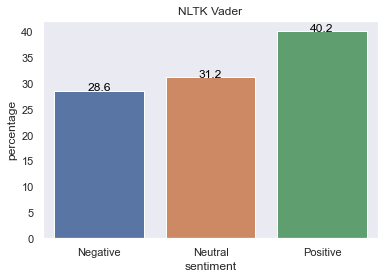

In [14]:
sns.set_theme(style="dark")
ax = sns.barplot(x="sentiment", y="percentage", data=nltk_sentiment_df)
ax.set_title('NLTK Vader')

for index, row in nltk_sentiment_df.iterrows():
    ax.text(row.name,row.percentage, round(row.percentage,1), color='black', ha="center")

___
<a name="sentiment_textblob"></a>
## Sentiment Analysis with TextBlob


In [15]:
tweets_df['textblob_score'] = tweets_df['text_cleaned'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [16]:
neutral_thresh = 0.05

In [17]:
tweets_df['textblob_sentiment'] = tweets_df['textblob_score'].apply(lambda c: 'Positive' if c >= neutral_thresh else ('Negative' if c <= -(neutral_thresh) else 'Neutral'))



In [18]:
tweets_df['textblob_score'].describe()

count    24500.000000
mean         0.094818
std          0.220808
min         -1.000000
25%          0.000000
50%          0.000000
75%          0.200000
max          1.000000
Name: textblob_score, dtype: float64

In [19]:
textblob_sentiment_df = get_value_counts('textblob_sentiment','TextBlob')
textblob_sentiment_df

,sentiment,counts,percentage,analyzer
0,Negative,3452,14.09,TextBlob
1,Neutral,9729,39.71,TextBlob
2,Positive,11319,46.20,TextBlob


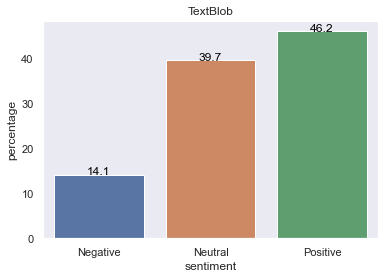

In [20]:
sns.set_theme(style="dark")
ax = sns.barplot(x="sentiment", y="percentage", data=textblob_sentiment_df)
ax.set_title('TextBlob')

for index, row in textblob_sentiment_df.iterrows():
    ax.text(row.name,row.percentage, round(row.percentage,1), color='black', ha="center")

___
<a name="sentiment_stanza"></a>
## Sentiment Analysis with Stanza


Score mapping:  
0: Negative  
1: Neutral  
2: Positive

In [21]:
nlp = stanza.Pipeline(lang='en', processors='tokenize,sentiment')

2022-06-01 23:56:32 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| sentiment | sstplus  |

2022-06-01 23:56:32 INFO: Use device: cpu
2022-06-01 23:56:32 INFO: Loading: tokenize
2022-06-01 23:56:35 INFO: Loading: sentiment
2022-06-01 23:56:37 INFO: Done loading processors!


In [22]:
def stanza_analyze(Text):
    document = nlp(Text)
    print('Processing')
    return np.mean([(i.sentiment - 1) for i in document.sentences]) 

In [23]:
tweets_df['stanza_score'] = tweets_df['text_cleaned'].apply(lambda x: stanza_analyze(x))

Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing

In [24]:
tweets_df['stanza_score'].describe()

count    24500.000000
mean        -0.243238
std          0.549302
min         -1.000000
25%         -0.666667
50%          0.000000
75%          0.000000
max          1.000000
Name: stanza_score, dtype: float64

In [25]:
neutral_thresh = 0.05

In [26]:
tweets_df['stanza_sentiment'] = tweets_df['stanza_score'].apply(lambda c: 'Positive' if c >= neutral_thresh else ('Negative' if c <= -(neutral_thresh) else 'Neutral'))

In [27]:
stanza_sentiment_df = get_value_counts('stanza_sentiment','Stanza')
stanza_sentiment_df

,sentiment,counts,percentage,analyzer
0,Negative,11169,45.59,Stanza
1,Neutral,9968,40.69,Stanza
2,Positive,3363,13.73,Stanza


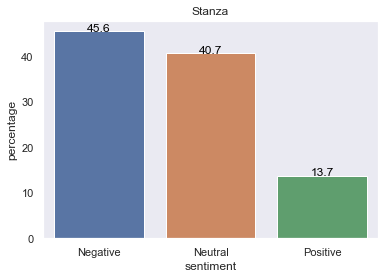

In [28]:
sns.set_theme(style="dark")
ax = sns.barplot(x="sentiment", y="percentage", data=stanza_sentiment_df)
ax.set_title('Stanza')

for index, row in stanza_sentiment_df.iterrows():
    ax.text(row.name,row.percentage, round(row.percentage,1), color='black', ha="center")

___
<a name="insights"></a>
## Insights from Sentiment Analyses


In [29]:
df_sentiments = pd.concat([nltk_sentiment_df, 
                           textblob_sentiment_df, 
                           stanza_sentiment_df,
                          
                          ]).reset_index(drop=True)
df_sentiments

,sentiment,counts,percentage,analyzer
0,Negative,7005,28.59,NLTK Vader
1,Neutral,7650,31.22,NLTK Vader
2,Positive,9845,40.18,NLTK Vader
3,Negative,3452,14.09,TextBlob
4,Neutral,9729,39.71,TextBlob
5,Positive,11319,46.20,TextBlob
6,Negative,11169,45.59,Stanza
7,Neutral,9968,40.69,Stanza
8,Positive,3363,13.73,Stanza


In [30]:
df_sentiments_pivot = df_sentiments.pivot(index='sentiment', columns='analyzer', values='percentage')
df_sentiments_pivot

analyzer,NLTK Vader,Stanza,TextBlob
sentiment,,,
Negative,28.59,45.59,14.09
Neutral,31.22,40.69,39.71
Positive,40.18,13.73,46.20


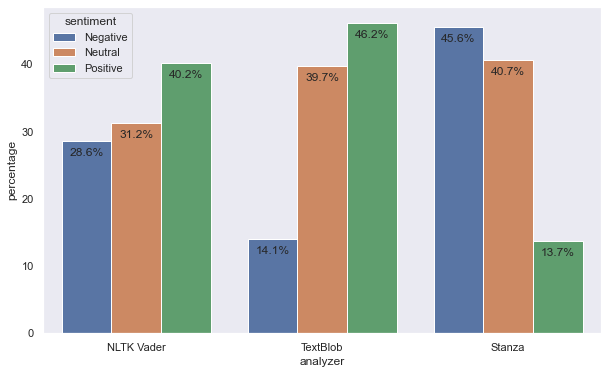

In [31]:
plt.figure(figsize=(10,6))
ax = sns.barplot(x="analyzer", y="percentage",
                 hue="sentiment", data=df_sentiments)

for p in ax.patches:
    ax.annotate(f"{round(p.get_height(),1)}%", 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=12,
                   xytext = (0, -12), 
                   textcoords = 'offset points')

___
<a name="ensemble"></a>
## Composite Sentiment with Ensemble Method

In [32]:
tweets_df['composite_score'] =  (tweets_df['nltk_cmp_score'] 
                                + tweets_df['textblob_score']
                                + tweets_df['stanza_score'])/3

In [33]:
tweets_df['composite_score'].describe()

count    24500.000000
mean        -0.030064
std          0.309953
min         -0.951833
25%         -0.256406
50%          0.000000
75%          0.152450
max          0.956300
Name: composite_score, dtype: float64

In [34]:
neutral_thresh = 0.05

In [35]:
tweets_df['composite_vote_2'] = tweets_df['composite_score'].apply(lambda c: 'Positive' if c >= neutral_thresh else ('Negative' if c <= -(neutral_thresh) else 'Neutral'))

In [36]:
composite_sentiment_df_2 = get_value_counts('composite_vote_2','Composite Sentiment')
composite_sentiment_df_2

,sentiment,counts,percentage,analyzer
0,Negative,10635,43.41,Composite Sentiment
1,Neutral,5077,20.72,Composite Sentiment
2,Positive,8788,35.87,Composite Sentiment


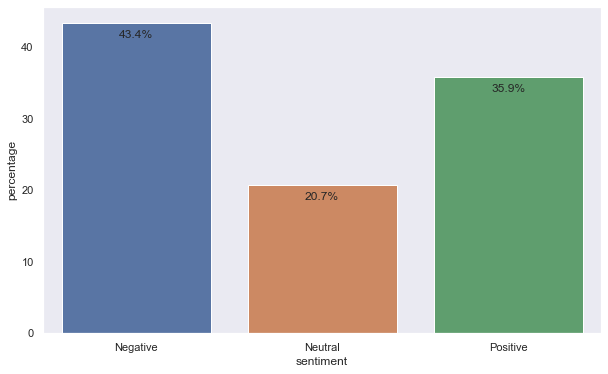

In [37]:
plt.figure(figsize=(10,6))
ax = sns.barplot(x="sentiment", y="percentage",
                 data=composite_sentiment_df_2)

for p in ax.patches:
    ax.annotate(f"{round(p.get_height(),1)}%", 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=12,
                   xytext = (0, -12), 
                   textcoords = 'offset points')

___
#### Experiment: Max Voting
- Get composite sentiment by doing max voting amongst the 3 analyzers NLTK Vader, TextBlob and Stanza

In [38]:
tweets_df['sentiment_votes'] =  tweets_df.apply(lambda x: list([x['nltk_sentiment'], 
                                                                x['textblob_sentiment'], 
                                                                x['stanza_sentiment']]),axis=1) 

In [39]:
def get_most_voted_senti(List):
    if len(List) == len(set(List)): 
        return 'Neutral'
    else:
        return max(set(List), key = List.count)

In [40]:
tweets_df['composite_vote'] = tweets_df['sentiment_votes'].apply(lambda x: get_most_voted_senti(x))

In [41]:
composite_sentiment_df = get_value_counts('composite_vote','Composite Sentiment (Max Voting)')
composite_sentiment_df

,sentiment,counts,percentage,analyzer
0,Negative,6217,25.38,Composite Sentiment (Max Voting)
1,Neutral,11215,45.78,Composite Sentiment (Max Voting)
2,Positive,7068,28.85,Composite Sentiment (Max Voting)


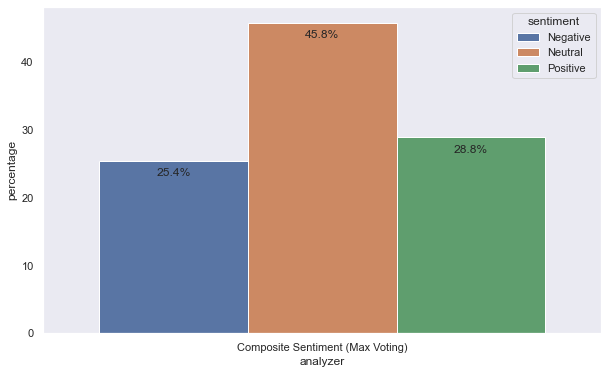

In [42]:
plt.figure(figsize=(10,6))
ax = sns.barplot(x="analyzer", y="percentage",
                 hue="sentiment", data=composite_sentiment_df)

for p in ax.patches:
    ax.annotate(f"{round(p.get_height(),1)}%", 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=12,
                   xytext = (0, -12), 
                   textcoords = 'offset points')

In [43]:
tweets_df['composite_vote']=='Positive'
tweets_df.head()

,username,location,text,tweet_date,hashtags_extracted,text_cleaned,nltk_scores,nltk_cmp_score,nltk_sentiment,textblob_score,textblob_sentiment,stanza_score,stanza_sentiment,composite_score,composite_vote_2,sentiment_votes,composite_vote
0,Habari Entertainment,Phoenix,Illinois COVID Update Today: IL reports 802 ca...,2021-05-29 23:59:58,covid19,"Illinois COVID Update Today IL reports cases, ...","{'neg': 0.0, 'neu': 0.763, 'pos': 0.237, 'comp...",0.4215,Positive,0.000000,Neutral,-0.500000,Negative,-0.026167,Neutral,"[Positive, Neutral, Negative]",Neutral
1,Beverly,New York,Bombshell New study says Chinese scientists cr...,2021-05-29 23:57:46,"covid19,media,usa",Bombshell New study says Chinese scientists cr...,"{'neg': 0.099, 'neu': 0.843, 'pos': 0.058, 'co...",-0.3400,Negative,0.046591,Neutral,-0.333333,Negative,-0.208914,Negative,"[Negative, Neutral, Negative]",Negative
2,Boston Athlete Magazine,United States,Boston Athlete News - Today begins lifting of ...,2021-05-29 23:56:28,"cityofboston,boston,massachusetts,bostonathlet...",Boston Athlete News - Today begins lifting of ...,"{'neg': 0.102, 'neu': 0.898, 'pos': 0.0, 'comp...",-0.3818,Negative,0.000000,Neutral,0.000000,Neutral,-0.127267,Negative,"[Negative, Neutral, Neutral]",Neutral
3,vare ramankumar,NaN,@MoHFW_INDIA @PrakashJavdekar @PMOIndia @drhar...,2021-05-29 23:56:07,NaN,I salute to Our Honourable Union Health Minist...,"{'neg': 0.0, 'neu': 0.871, 'pos': 0.129, 'comp...",0.6705,Positive,0.000000,Neutral,0.000000,Neutral,0.223500,Positive,"[Positive, Neutral, Neutral]",Neutral
4,Tom,"Kildare, Ireland",Is 'Patient Su' Covid's Patient Zero? asks IAN...,2021-05-29 23:55:14,"covid19,wuhanlab",Is 'Patient Su' Covid's Patient Zero? asks IAN...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral,0.000000,Neutral,0.000000,Neutral,0.000000,Neutral,"[Neutral, Neutral, Neutral]",Neutral


In [44]:
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk import sent_tokenize, word_tokenize
from wordcloud import WordCloud, STOPWORDS
def wc(data,bgcolor,title):
    plt.figure(figsize = (100,100))
    wc = WordCloud(background_color = bgcolor, max_words = 1000,  max_font_size = 50)
    wc.generate(' '.join(data))
    plt.imshow(wc)
    plt.axis('off')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\4jasv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [45]:
from collections import Counter
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
import nltk
nltk.download('punkt')
import re
def barp(types):
    top_N = 100
    #convert list of list into text
    #a=''.join(str(r) for v in df_usa['title'] for r in v)
    pos=tweets_df.query("composite_vote=='"+types+"'")

    a = pos['text'].str.lower().str.cat(sep=' ')

    # removes punctuation,numbers and returns list of words
    b = re.sub('[^A-Za-z]+', ' ', a)

    #remove all the stopwords from the text
    stop_words = list(get_stop_words('en'))         
    nltk_words = list(stopwords.words('english'))   
    stop_words.append('https')
    stop_words.append('amp')
    stop_words.append('covid')


    stop_words.extend(nltk_words)

    word_tokens = word_tokenize(b)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    filtered_sentence = []
    for w in word_tokens:
        if w not in stop_words:
            filtered_sentence.append(w)

    # Remove characters which have length less than 2  
    without_single_chr = [word for word in filtered_sentence if len(word) > 2]

    # Remove numbers
    cleaned_data_title = [word for word in without_single_chr if not word.isnumeric()]        

    # Calculate frequency distribution
    word_dist = nltk.FreqDist(cleaned_data_title)
    rslt = pd.DataFrame(word_dist.most_common(top_N),
                        columns=['Word', 'Frequency'])

    plt.figure(figsize=(10,10))
    sns.set_style("whitegrid")
    ax = sns.barplot(x="Word",y="Frequency", data=rslt.head(7))
    wc(cleaned_data_title,'black','Common Words' )


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\4jasv\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


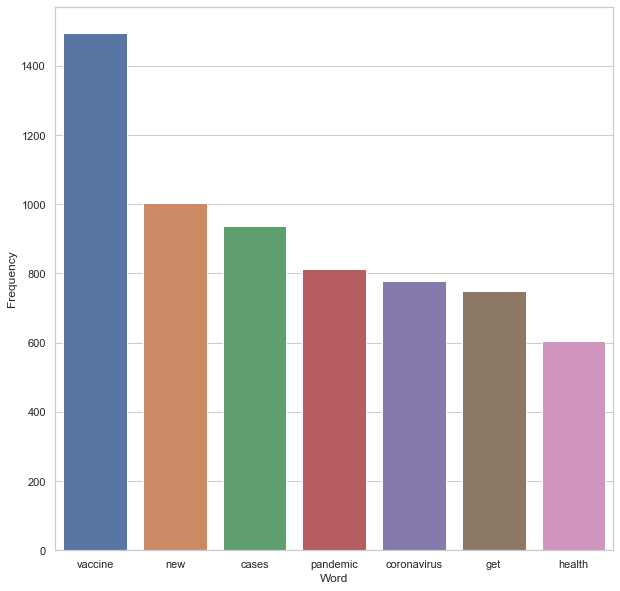

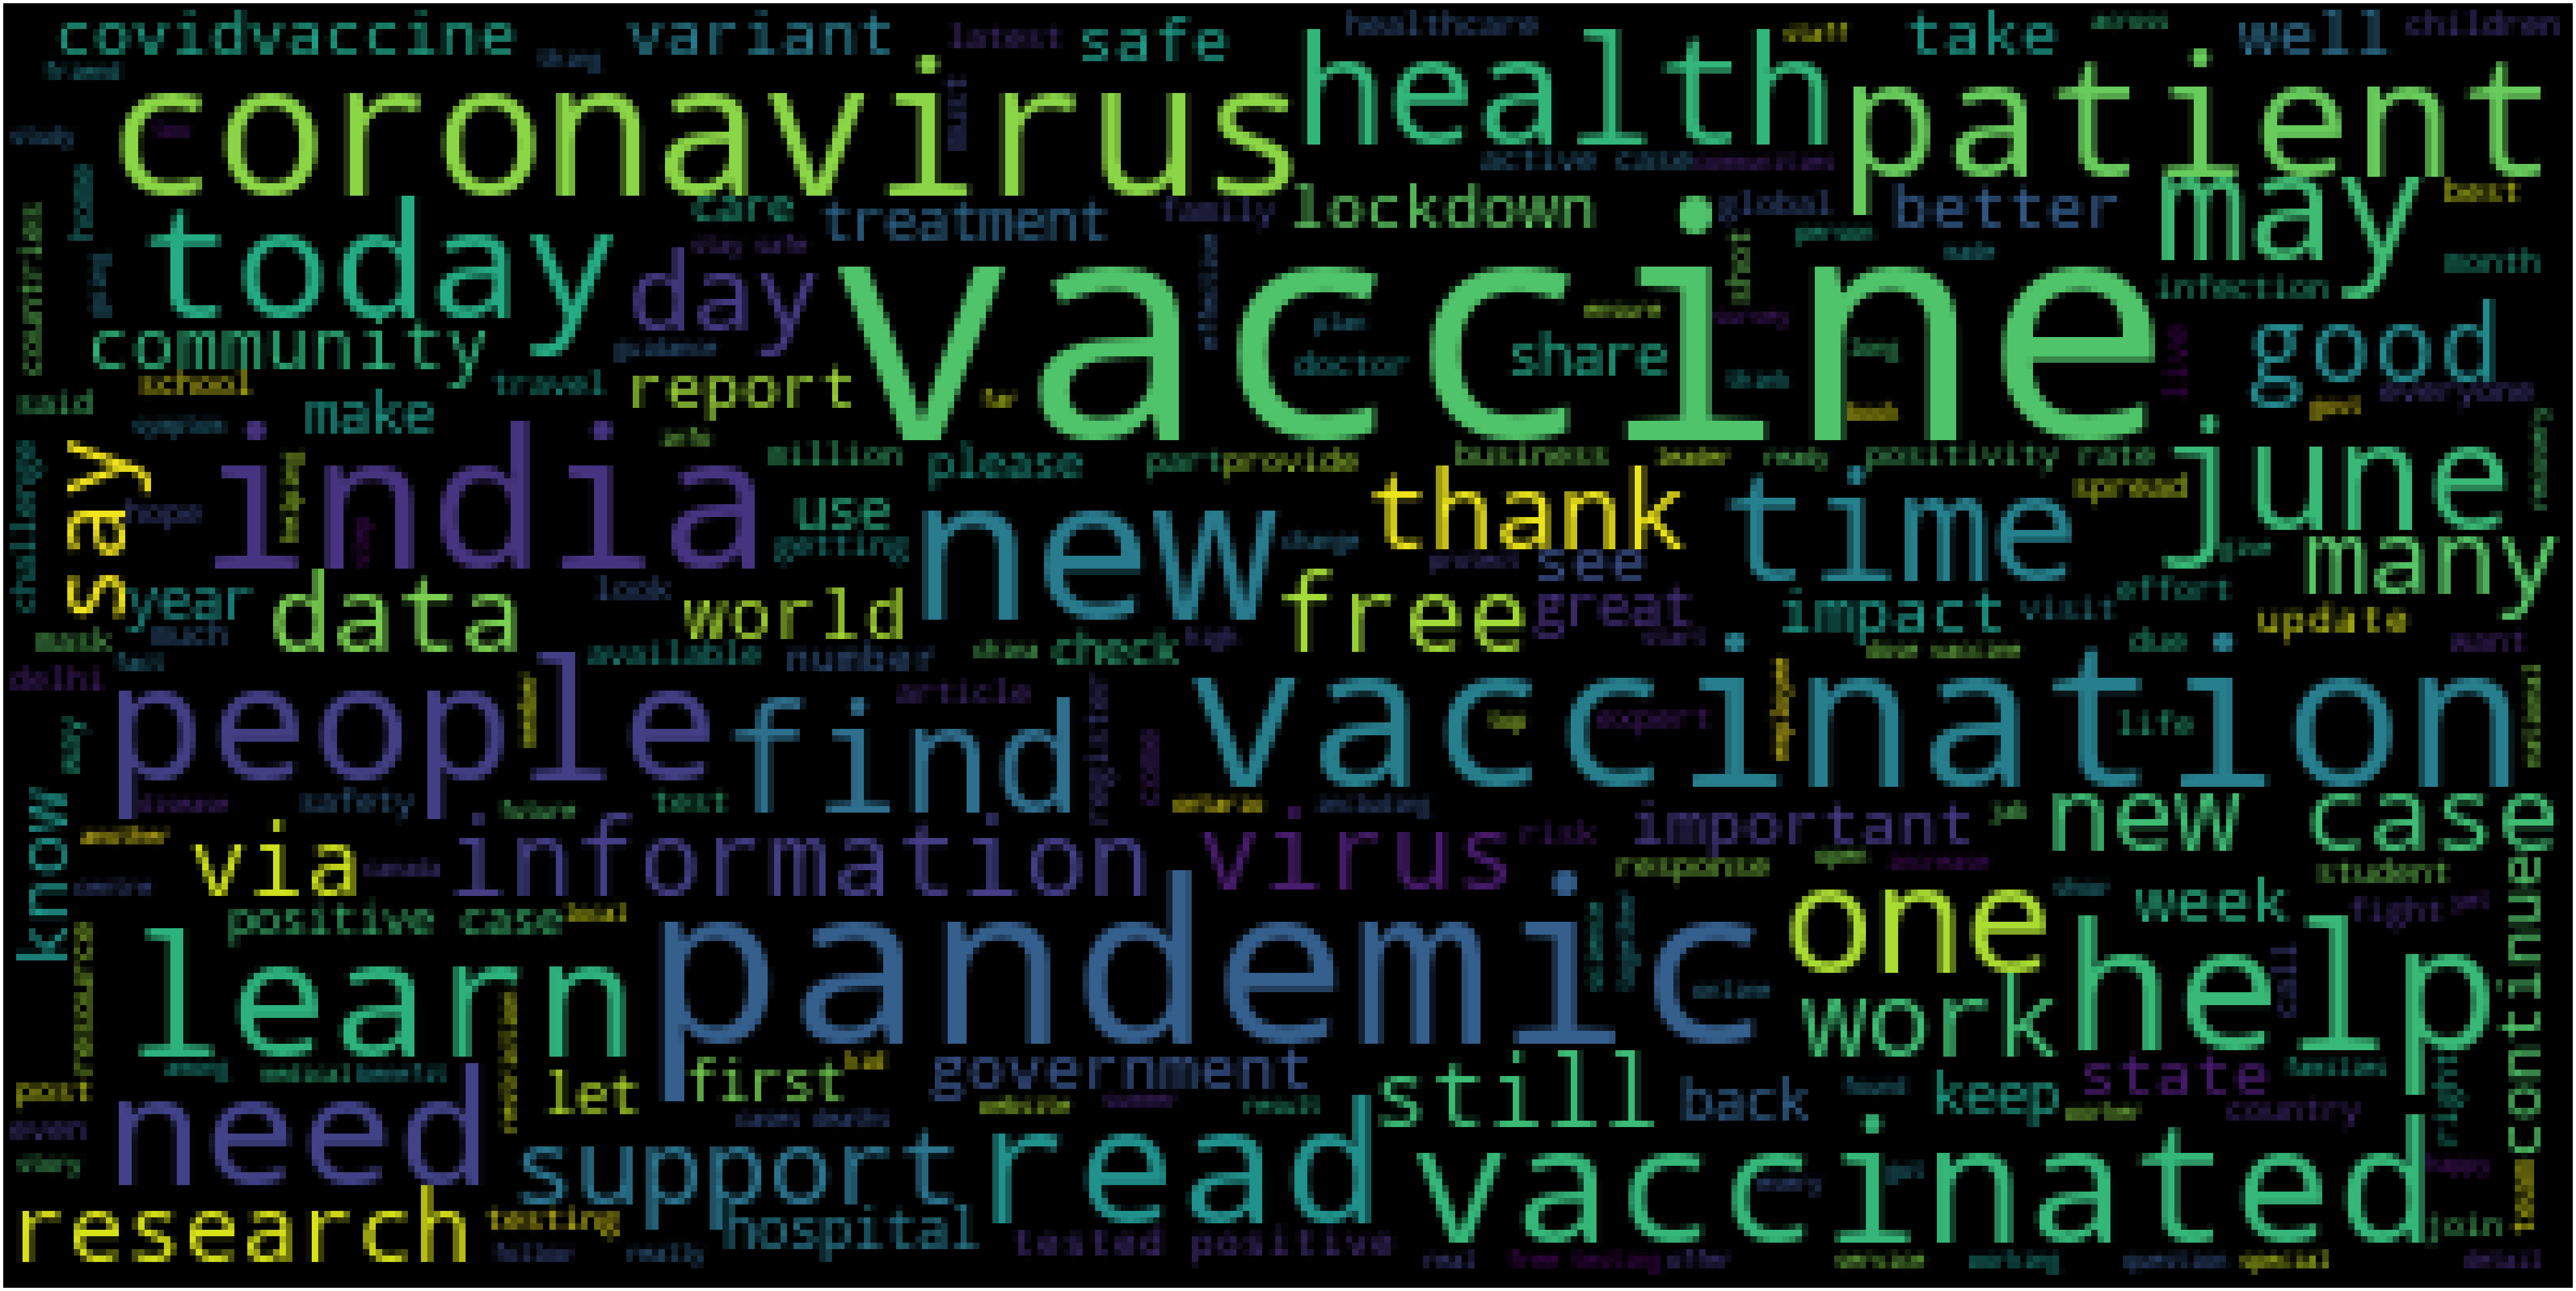

In [46]:
barp('Positive')

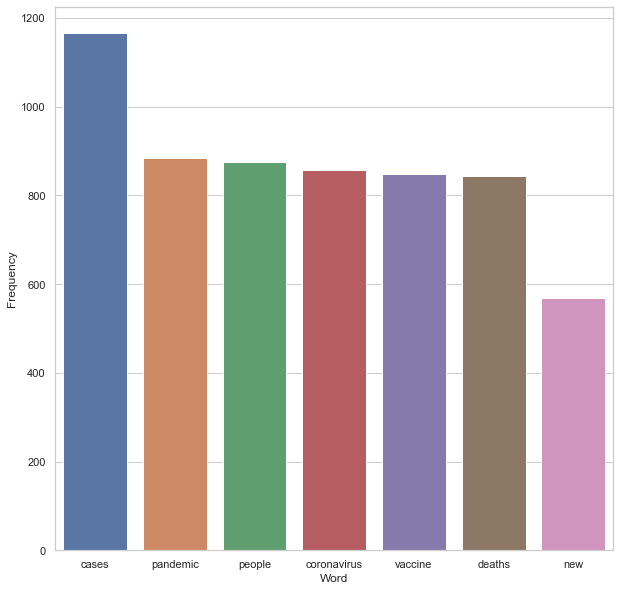

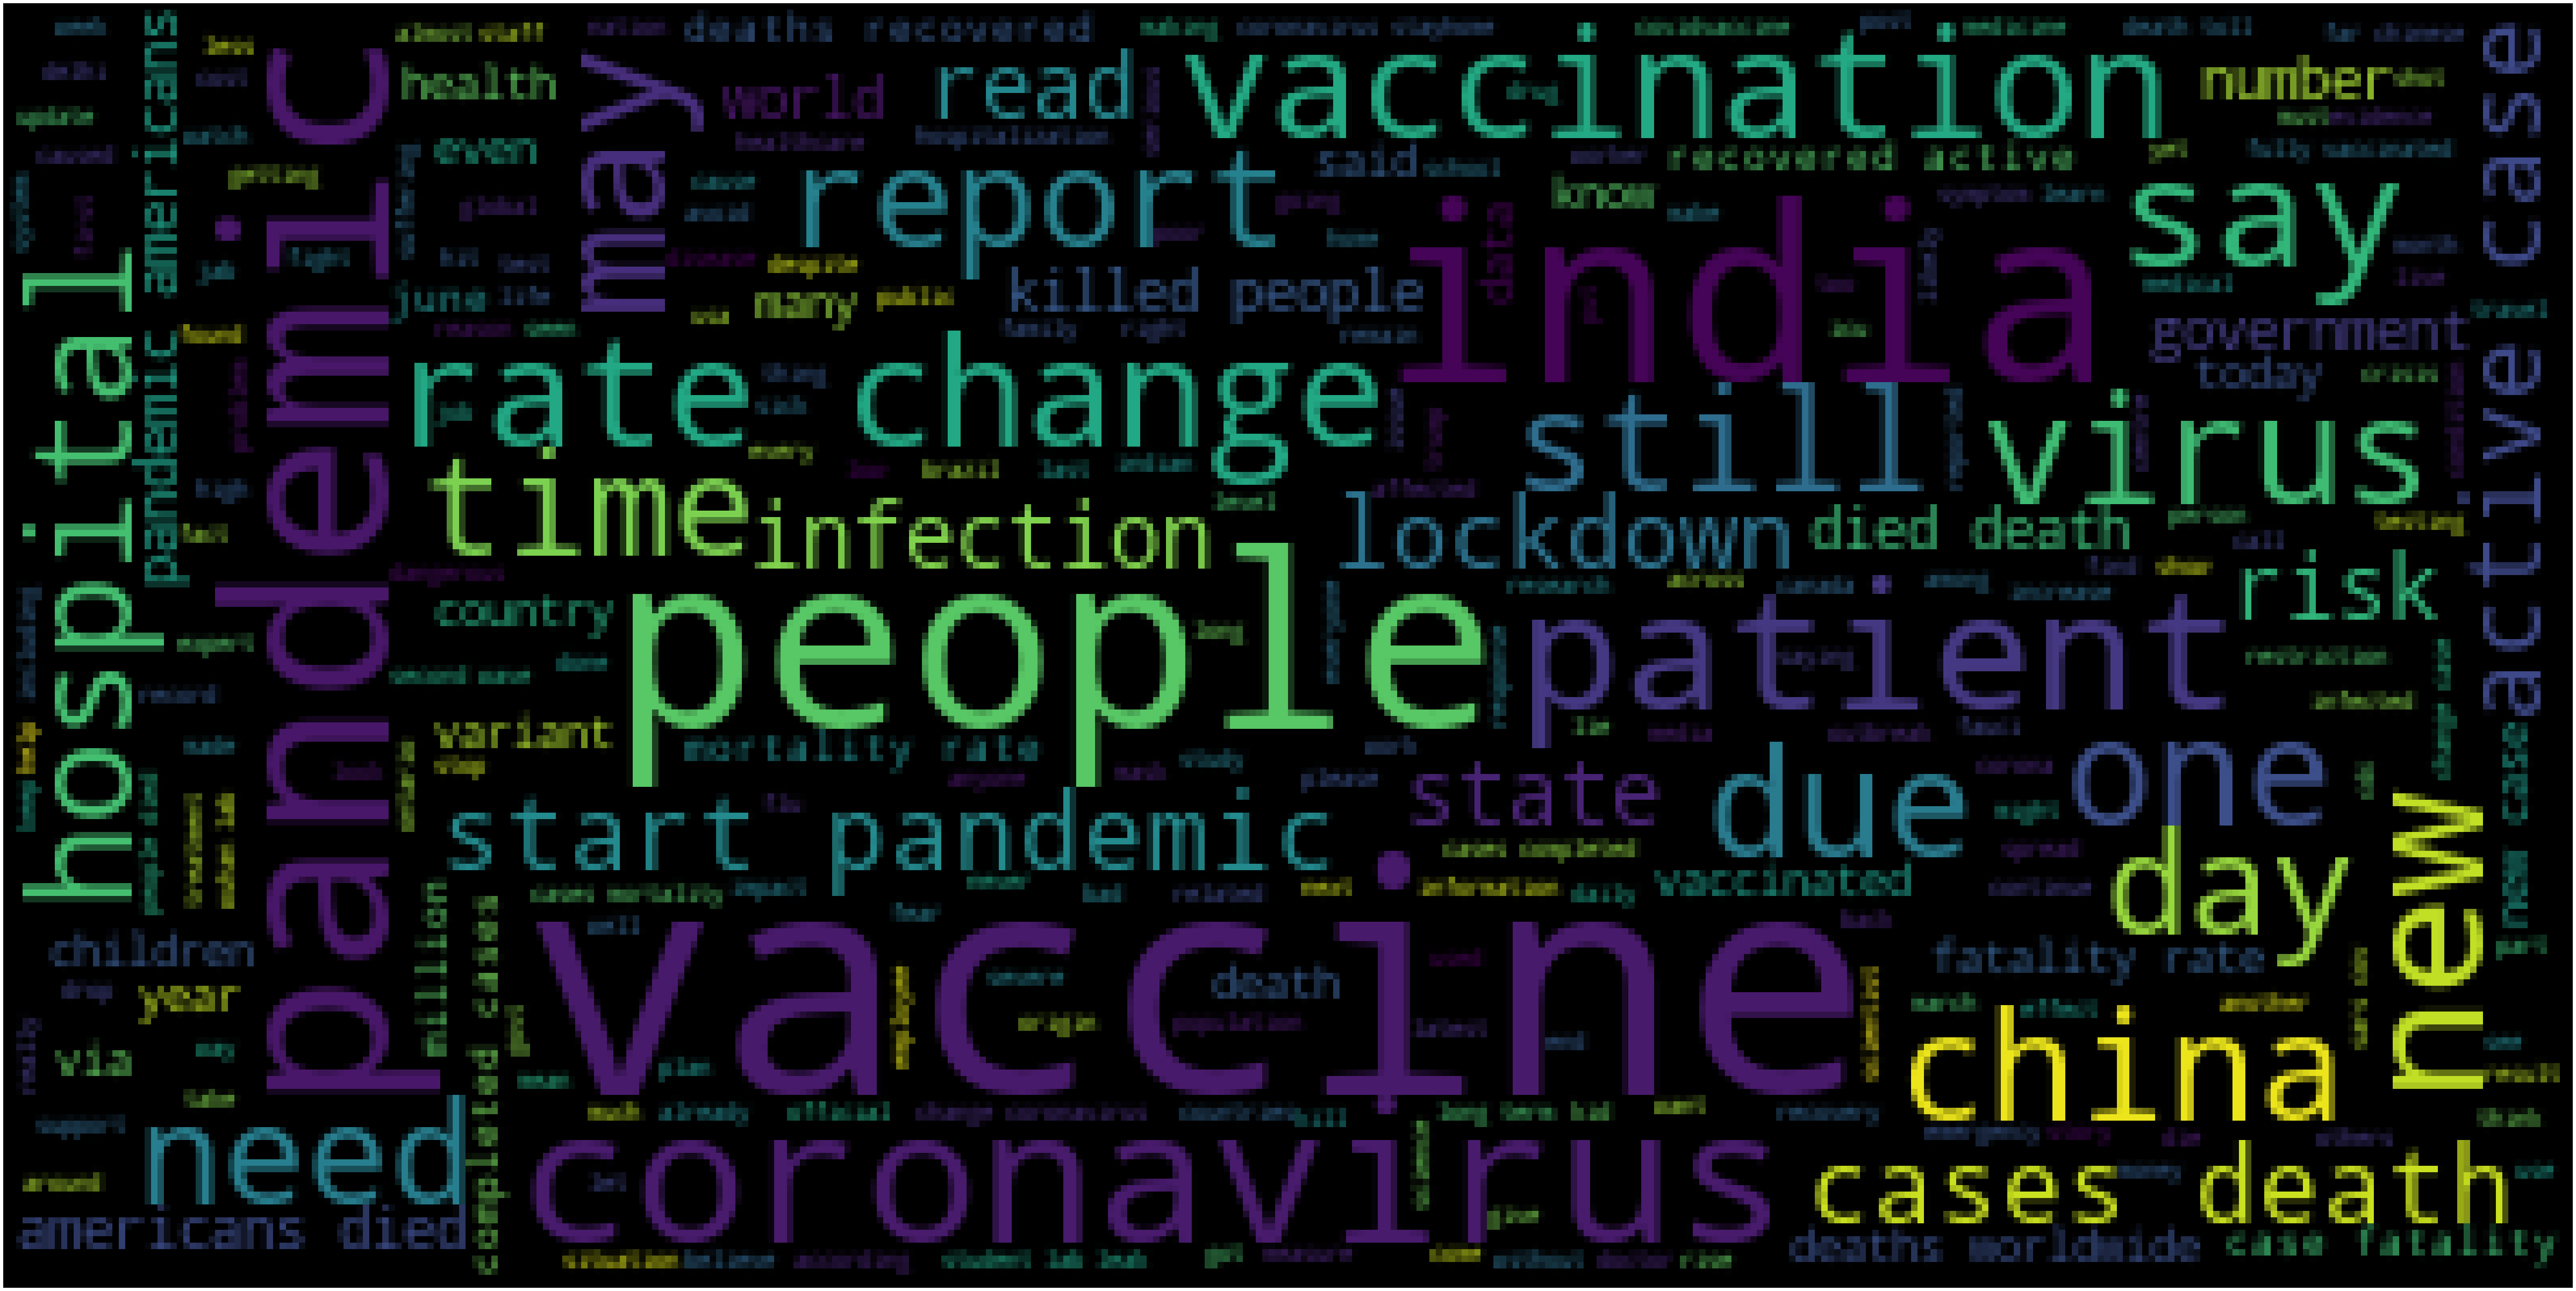

In [47]:
barp('Negative')

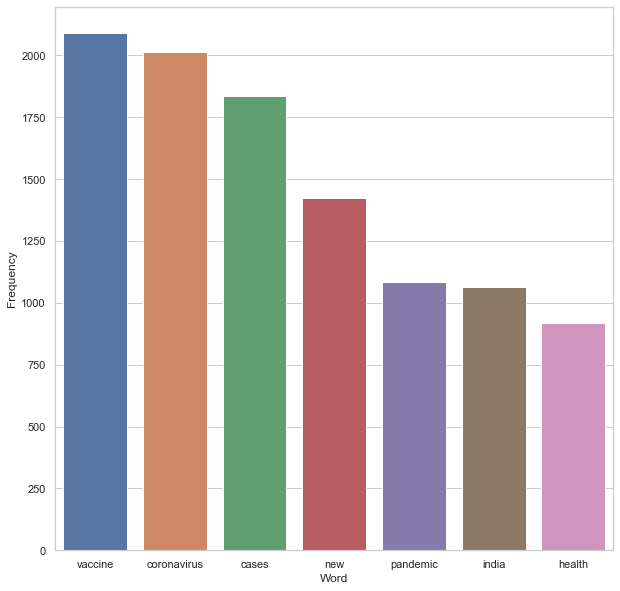

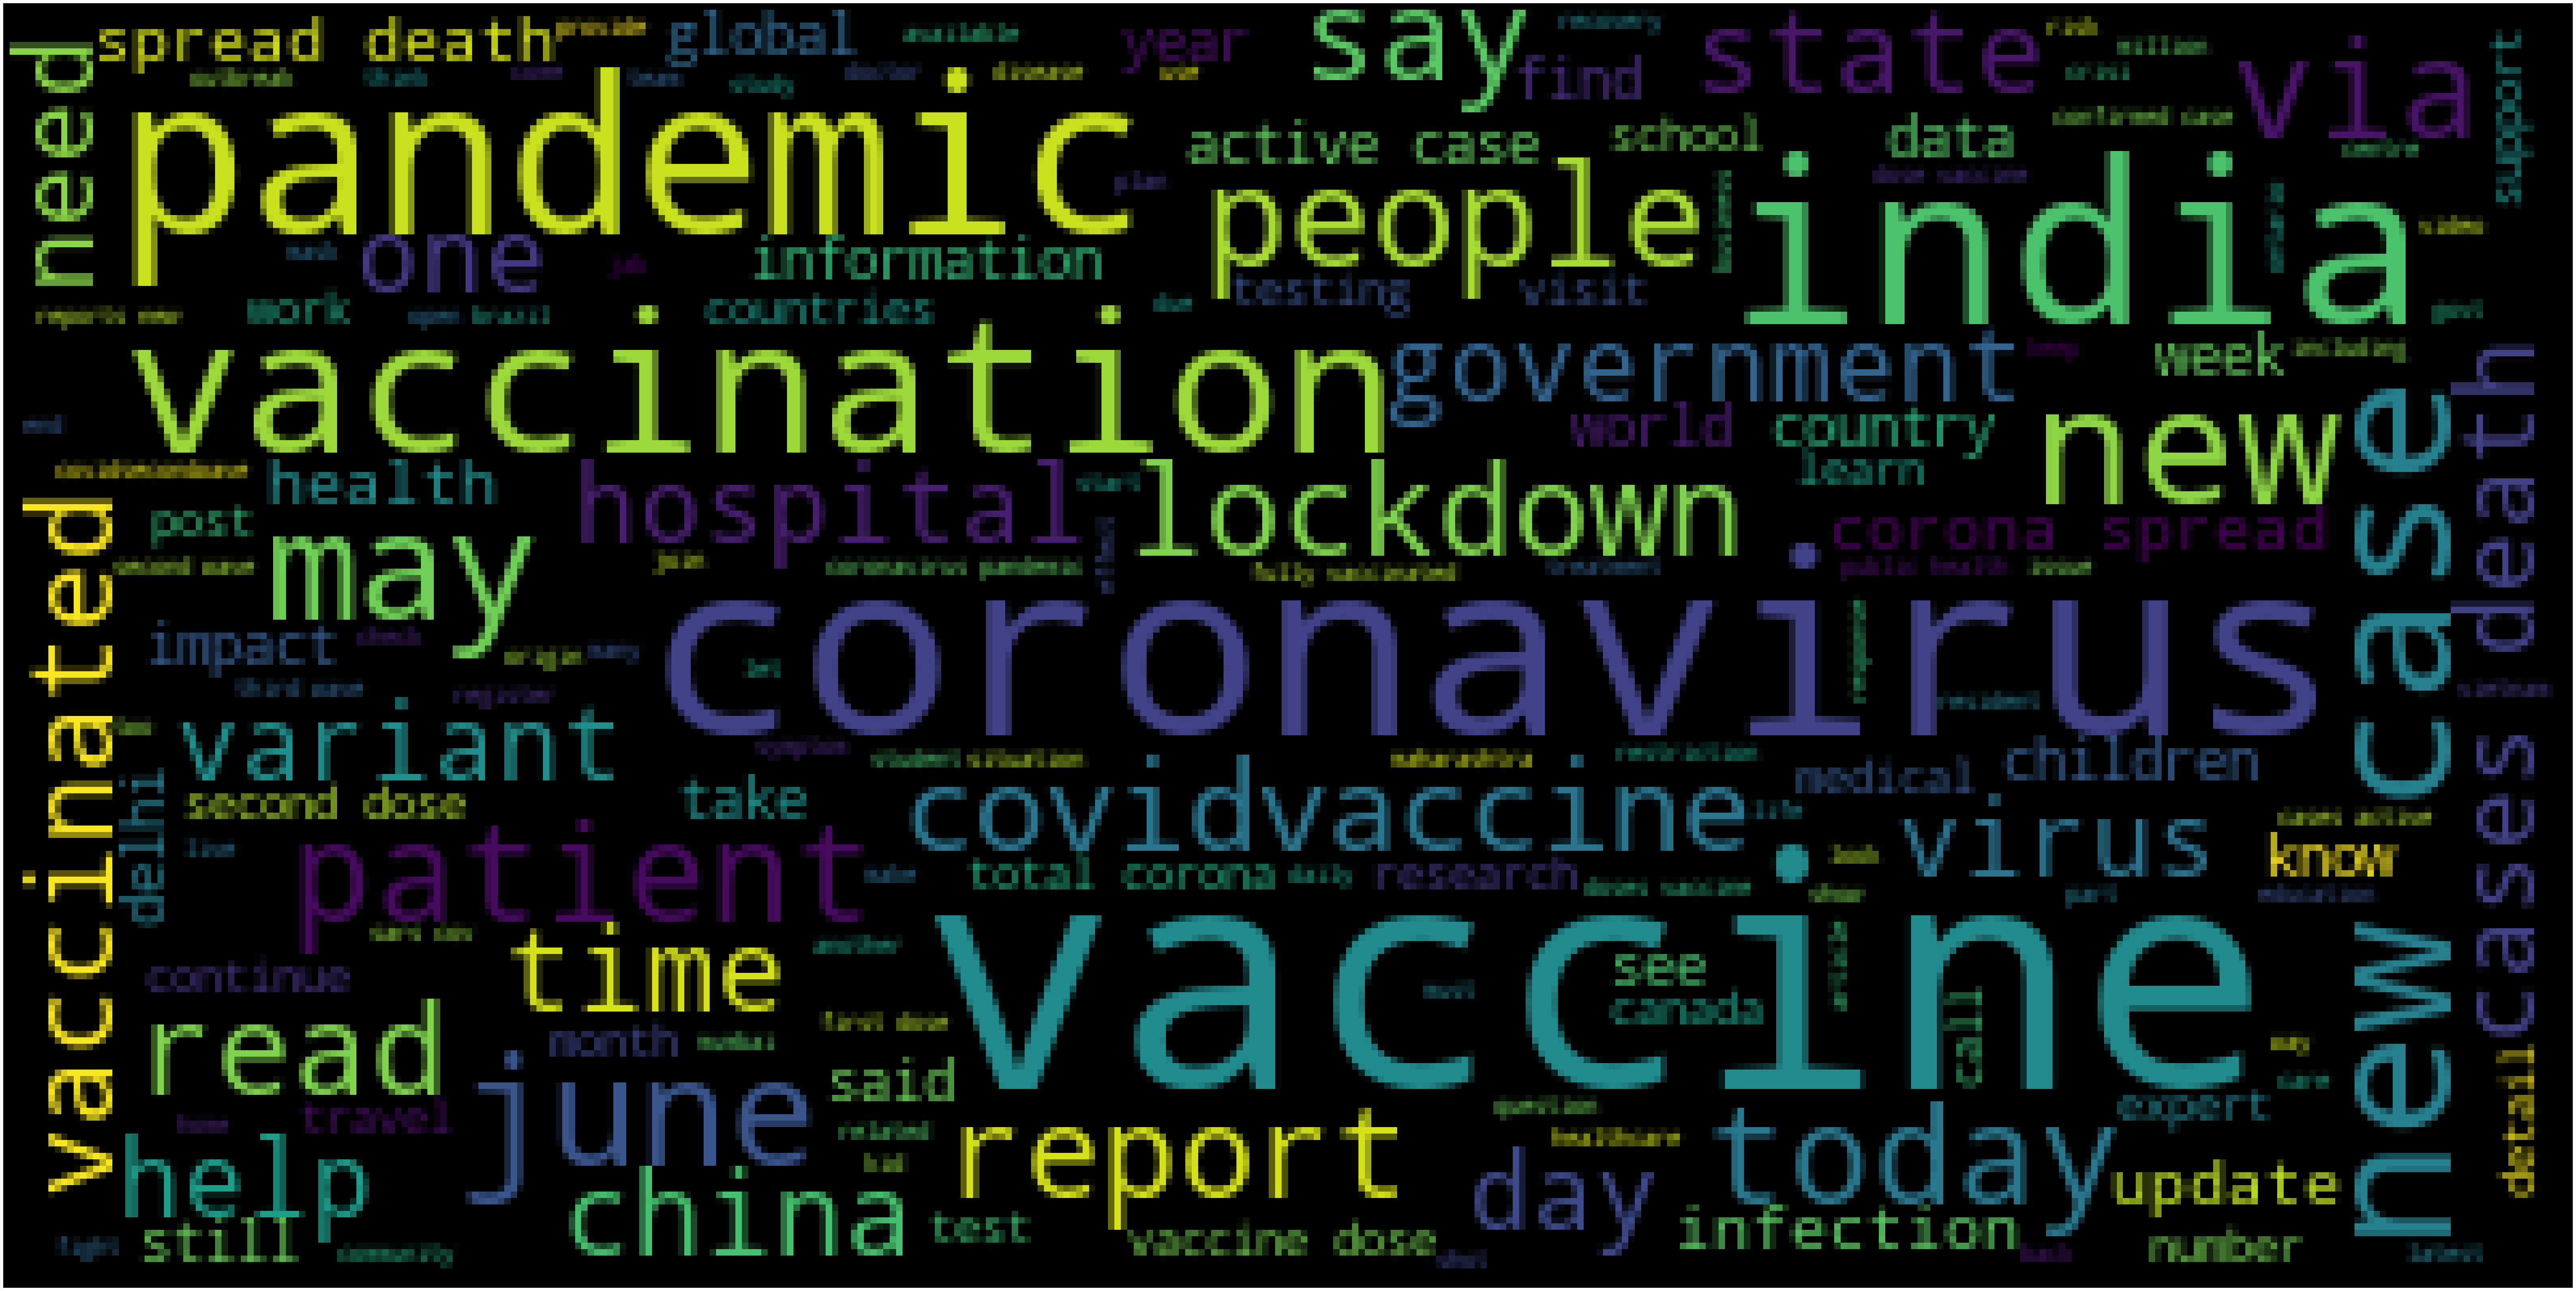

In [48]:
barp('Neutral')